<a href="https://colab.research.google.com/github/KateT840/M-computacionales-1/blob/main/Parcial_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emcee
!pip install corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.1 MB/s eta 0:00:00


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner
import os
from google.colab import drive
import scipy.optimize as spo
from scipy.stats import poisson, norm
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [18]:
os.chdir("/content/drive/MyDrive/ColabNotebooks1")
!ls

 DataExponencial1.csv	   DatosRegresion.csv   MinimosCuadratico.txt
 DataExponencial.csv	   Gaussiano.csv        MinimosLineal.txt
'DatosRegresion (1).csv'   MediaMovilData.csv


In [129]:
x1 = np.array([15, 15, 13, 17, 15])
x2 = np.array([18, 20, 16, 21, 15])
_x = (x1, x2)
p0 = [1.5, 0.7, 0.8]

In [142]:
#Estimación de la tasa de muones con dos centelladores.
#Punto 1:
def log_likelihood(p, x):
    lam, eps1, eps2 = p
    if lam <= 0 or eps1 <= 0 or eps2 <= 0:
        return -np.inf
    x1, x2 = x
    t = 10
    mu1 = lam * t * eps1
    mu2 = lam * t * eps2
    return np.sum(poisson.logpmf(x1, mu=mu1)) + np.sum(poisson.logpmf(x2, mu=mu2))

In [143]:
log_likelihood(p0, _x)

np.float64(-34.94264074378715)

In [144]:
#Punto 2:
lambdas = np.linspace(1.0, 2.0, 10)
eps1s = np.linspace(0.4, 1.0, 10)
eps2s = np.linspace(0.4, 1.2, 10)

In [145]:
#Punto 3
def log_prior(p):
    lam, eps1, eps2 = p
    if lam <= 0 or not (0 < eps1 <= 1.0) or not (0 < eps2 <= 1.0):
      return -np.inf
    lp_eps1 = norm.logpdf(eps1, loc=0.7, scale=0.1)
    lp_eps2 = norm.logpdf(eps2, loc=0.8, scale=0.3)
    return lp_eps1 + lp_eps2

In [146]:
log_prior(p0)

np.float64(1.6686808309106362)

In [147]:
def log_posterior(p, x):
    lp = log_prior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(p, x)

In [148]:
log_posterior(p0,_x)

np.float64(-33.273959912876514)

In [149]:
n_walkers, n_params = 50, 3
initial = np.array([1.5, 0.7, 0.8])
pos = initial + 1e-4 * np.random.randn(n_walkers, n_params)
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args=(x,))
pos,prob,state = sampler.run_mcmc(pos,10000,progress=True)

100%|██████████| 10000/10000 [04:44<00:00, 35.13it/s]


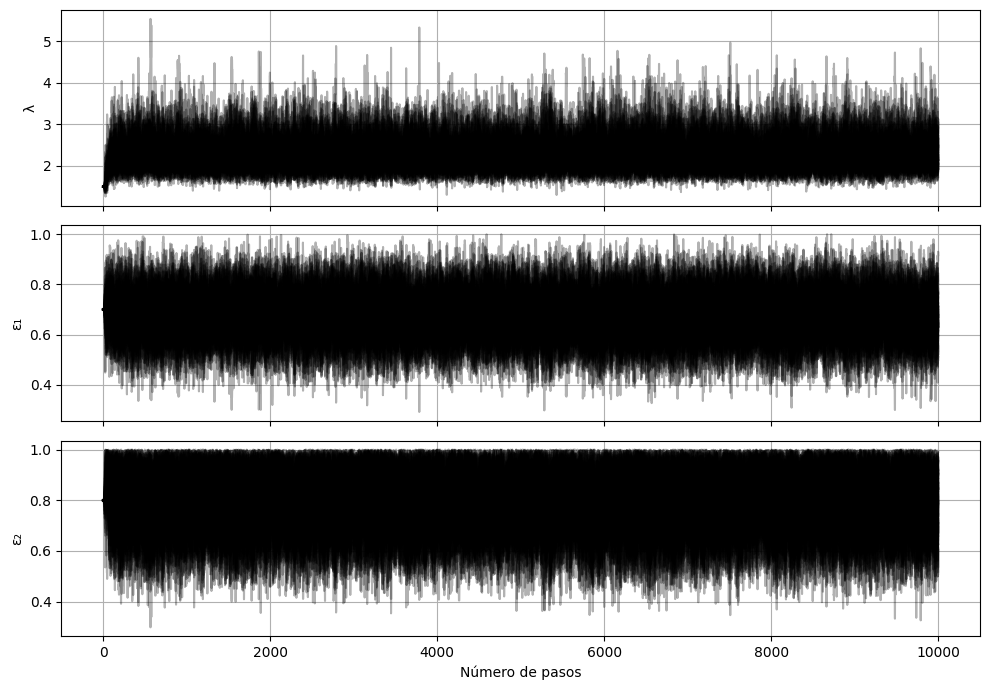

In [151]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels =  ["λ", "ε₁", "ε₂"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.grid()

axes[-1].set_xlabel("Número de pasos")
plt.tight_layout()
plt.show()

In [152]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
truths = np.percentile(flat_samples, 50, axis=0)
truths

array([2.23741264, 0.67924926, 0.8010794 ])

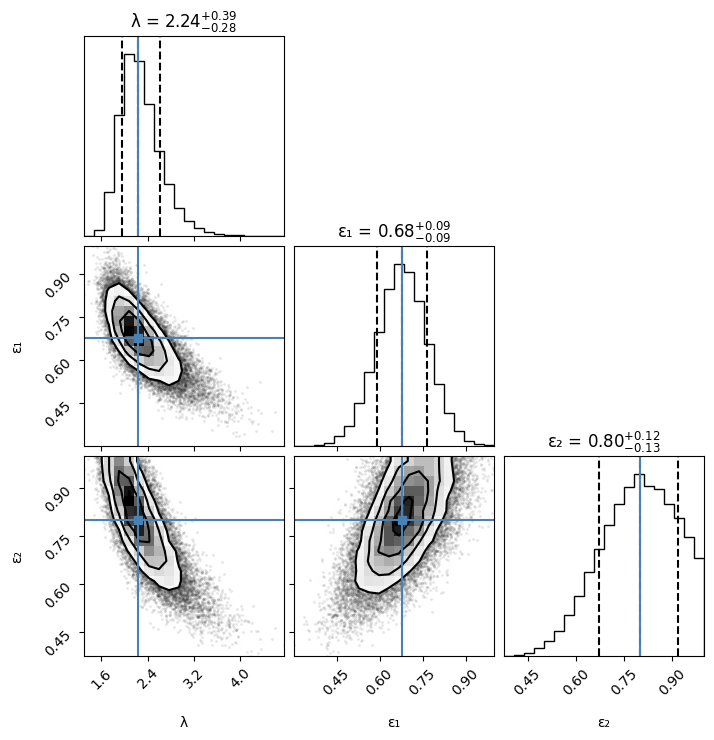

In [153]:
figure = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16,0.5,0.84], show_titles=True)